In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

In [2]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, Imputer
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, roc_auc_score

from sklearn.svm import LinearSVC 
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss, InstanceHardnessThreshold
from collections import Counter, defaultdict

## Функция обработки данных

In [89]:
# Функция для преобразования данных
# num_cols - числовые признаки, которые будут использоваться
# cat_cols - категориальные признаки, которые будут использоваться
# опции: is_OHE - One Hot Encoding, 
# is_OverSampling - Over Sampling
# imput_method - способ заполнения пропущенных числовых данных
# feature_selection - метод отбора признаков 

# По умолчанию используется все признаки, все опции выключены, imput_method='normalize'
# Для обработки категориальных данных по умолчанию используется только Label Encoder

def transform_data(data, y=None, imput_method='normalize', feature_selection=None,
                   num_cols=None, cat_cols=None, is_OHE=False, is_OverSampling=False):
    
    to_return = {}
    
    num_interval = (0, 190)
    cat_interval = (191, data.shape[1])
    
    
    data, num_interval, cat_interval, new_cols = drop_null_cols(data, num_interval, cat_interval)
    
    data_num, data_cat = split_num_cat(data, num_interval)
    
    if num_cols:
        data_num = data[num_cols]
        num_interval = (0, len(num_cols))
        diff = 190 - len(num_cols)
        cat_interval = (191 - diff, data.shape[1]-diff)
        new_cols.drop(num_cols)
    if cat_cols:
        data_cat = data[cat_cols]
        cat_interval_prev = cat_interval
        cat_interval = (cat_interval_prev[0], cat_interval_prev[1]-len(cat_cols))
        new_cols.drop(cat_cols)
    
    print('Processing the numeric columns...')
    data_num = data_num_processing(data_num, method=imput_method)
        
    print('Processing the categorical columns...')
    data_cat = data_cat_fill_nan(data_cat)
    
    data_cat = data_cat_LE(data_cat)
    
    if is_OHE:    
        data_cat = data_cat_OHE(data_cat)
        
    data_result = data_join(data_num, data_cat).tocsr()
    
    if feature_selection:
        data_result, model, feature_importances, feature_ranking = data_feature_selection(data=data_result, y=y, 
                                                                         method=feature_selection,
                                                                         num_interval=num_interval,
                                                                         columns=new_cols, is_OHE=is_OHE)
                                                                         
        to_return['feature_importances'] = feature_importances
        to_return['model'] = model
        to_return['feature_ranking']=feature_ranking
        
    
    if is_OverSampling:
        data_result, to_return['y'] = data_OverSampling(data_result, y)
    
    to_return['X'] = data_result
    to_return['num_interval'] = num_interval
    to_return['cat_interval'] = cat_interval
        
    print('Done!')
    
    return to_return

In [94]:
# Функция удаления пустых колонок

def drop_null_cols(data, num_interval, cat_interval):
    
    print('Dropping the null columns...')
    dropped_num = []
    dropped_cat = []
    
    new_cols = data.columns
    
    for idx, each_col in enumerate(data.columns):
        if len(data[pd.isnull(data[each_col])==True])==data.shape[0]:
            if idx > 190:
                dropped_cat.append(each_col)
            else:
                dropped_num.append(each_col)
                
    for each_col in dropped_num:
        data.drop(each_col,axis = 1,inplace = True)
        print("Dropped num-type column: {0}".format(each_col))
    
    for each_col in dropped_cat:
        data.drop(each_col,axis = 1,inplace = True)
        print("Dropped cal-type column: {0}".format(each_col))
    
    max_num = 190 - len(dropped_num)
    
    print("Dropped {0} num-type cols and {1} cat-types cols".format(len(dropped_num), len(dropped_cat)))
    print("Num-type feature have the indices from {0} up to {1}.".format(0, max_num))
    print("Cal-type feature have the indices from {0} up to {1}.".format(max_num+1, data.shape[1]))
    
    new_cols = new_cols.drop(dropped_num).drop(dropped_cat)
    
    
    return data, (0, max_num), (max_num+1, data.shape[1]), new_cols

# Функция разделения числовых и категориальных признаков

def split_num_cat(data, num_interval):
    print('Splitting the numeric and categorical columns...')
    data_num, data_cat = np.split(data, [num_interval[1]], axis=1)
    return data_num, data_cat

# Функция обработки числовых данных
def data_num_processing(data_num, method='normalize'):
    
    if method == 'normalize':
        print('Filling the absent values with the columns\' means...')
        data_num_transformed = data_num.fillna(data_num.mean())
        print('Normalizing the data...')
        for each_col in data_num_transformed.columns:
            if data_num_transformed[each_col].std():
                data_num_transformed[each_col]=(data_num_transformed[each_col]-data_num_transformed[each_col].mean()) / float(data_num_transformed[each_col].std())
            else:
                data_num_transformed[each_col]=data_num_transformed[each_col]-data_num_transformed[each_col].mean()
    else:
        imputer = Imputer(strategy=method)
        columns = data_num.columns
        data_num_transformed = pd.DataFrame(imputer.fit_transform(data_num), columns=columns)
        
    return data_num_transformed

# Заполнение пустых ячеек категориальных признаков значением 'unknown'
def data_cat_fill_nan(data_cat):
    print('Filling the absent categorical values...')
    data_cat_trasformed = data_cat.fillna('unknown')
    return data_cat_trasformed

# Применение Label Encoder к категориальным данным
def data_cat_LE(data_cat):
    print('Applying a LabelEncoder to the categorical columns...')
    
    data_cat = data_cat.apply(lambda x: x.astype(str))
    data_cat_transformed = data_cat.apply(lambda x: x.astype('category'))
    
    MyLabelEncoder = defaultdict(LabelEncoder)
    data_cat_transformed = data_cat_transformed.apply(lambda x: MyLabelEncoder[x.name].fit_transform(x))
    
    return data_cat_transformed

# Применение One Hot Encoder к категориальным данным

def data_cat_OHE(data_cat):
    print('Applying a OneHotEncoder to categorical columns...')
    data_cat_transformed = OneHotEncoder().fit_transform(data_cat)
    return data_cat_transformed

# Соединение обработанных числовых и категориальных признаков после обработки

def data_join(data_num, data_cat):
    print('Joining the numerical and categorical columns...')
    data_num_sparsed = csr_matrix(data_num)
    data_cat_sparsed = csr_matrix(data_cat)
    
    data_result = hstack((data_num_sparsed, data_cat))
    
    return data_result

# OverSampling
# Применимо только если есть значения labels

def data_OverSampling(data, labels):
    print('OverSampling in progress...')
    ros = RandomOverSampler(random_state=0)
    X_num_cat_resampled, y_resampled = ros.fit_sample(data, labels['target'].ravel())
    return X_num_cat_resampled, y_resampled

# Отбор признаков
# Доступны два метода: l1-регуляризация и отбор на основе деревьев
def data_feature_selection(data, y, method, num_interval, columns, is_OHE):
    print('Appling the {}-based feature selection method'.format(method))
    if method == 'l1':
        lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(data, y)
        model = SelectFromModel(lsvc, prefit=True)
        data_transformed = model.transform(data)
        print('New shape of X-data is {}'.format(data_transformed.shape))
        importances = lsvc.coef_
    elif method == 'tree':
        clf = ExtraTreesClassifier().fit(data, y)
        model = SelectFromModel(clf, prefit=True)
        data_transformed = model.transform(data)
        print('New shape of X-data is {}'.format(data_transformed.shape))
        importances = clf.feature_importances_
        
    if not is_OHE:
        features_ranking = columns[importances.argsort()]
    else:
        indices = np.arange(num_interval[1])
        num_importances = np.take(np.array(importances), indices)
        features_ranking = columns[num_importances.argsort()]
    
    return data_transformed, model, importances, features_ranking

# Функция расчета метрик отложенной выборки
def get_scores_hold_out(X_hold_out, y_hold_out, Classifier, configuration, scores):
    
    print('Calculating scores...')
    
    y_proba = Classifier.predict_proba(X_hold_out)[:, 1]
    y_pred = Classifier.predict(X_hold_out)

    results = precision_recall_fscore_support(y_hold_out, y_pred)
    pr_scores = average_precision_score(y_hold_out, y_proba)
    roc_auc_scores = roc_auc_score(y_hold_out, y_proba)
    
    scores.loc[configuration, 'precision'] = results[0][1]
    scores.loc[configuration, 'recall'] = results[1][1]
    scores.loc[configuration, 'f1-score'] = results[2][1]
    
    scores.loc[configuration, 'PR-score'] = pr_scores
    scores.loc[configuration, 'ROC AUC'] = roc_auc_scores
    
    print('Done!')
    return True

# Функция расчета метрик основной выборки
def get_scores(X, y, Classifier, configuration, scores):
    
    skf = StratifiedKFold(n_splits=5, random_state=123)
    skf.get_n_splits(X, y)
    skf.split(X, y)
    
    print('Calculating scores...')
    results = cross_validate(Classifier, X, y, cv=skf, scoring=['precision', 'recall', 'f1', 'average_precision', 'roc_auc'], return_train_score=True)
    
    scores.loc[configuration, 'precision test'] = results['test_precision'].mean()
    scores.loc[configuration, 'precision train'] = results['train_precision'].mean()
    scores.loc[configuration, 'recall test'] = results['test_recall'].mean()
    scores.loc[configuration, 'recall train'] = results['train_recall'].mean()
    scores.loc[configuration, 'f1-score test'] = results['test_f1'].mean()
    scores.loc[configuration, 'f1-score train'] = results['train_f1'].mean()
    scores.loc[configuration, 'PR-score test'] = results['test_average_precision'].mean()
    scores.loc[configuration, 'PR-score train'] = results['train_average_precision'].mean()
    scores.loc[configuration, 'ROC AUC test'] = results['test_roc_auc'].mean()
    scores.loc[configuration, 'ROC AUC train'] = results['train_roc_auc'].mean()
    
    print('Done!')
    return True

In [91]:
# Функция отрисовки кривых обучения
# Взято отсюда: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    
    if scoring:
        plt.ylabel(scoring)
    else:
        plt.ylabel('Score')
    
    if scoring:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
        
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [92]:
# Функция для изменения размера выборки с указанием доли положительного и отрицательного классов
# pos_frac - доля объектов положительного класса начальной выборки, которые будут использоваться в итоговой выборке
# neg_frac - доля объектов отрицательного класса начальной выборки, которые будут использоваться в итоговой выборке

def resample_data(X, y, pos_frac, neg_frac):
    
    pos_size = int(len(np.where(y==1)[0]) * pos_frac)
    neg_size = int(len(np.where(y==-1)[0]) * neg_frac)
    
    random.seed(1)
    pos_indices = random.sample(list(np.where(y== 1)[0]), pos_size)
    neg_indices = random.sample(list(np.where(y==-1)[0]), neg_size)
    
    y_pos = y[pos_indices]
    y_neg = y[neg_indices]
    y_result = np.append(y_pos, y_neg).ravel()
    
    X_pos = X[pos_indices]
    X_neg = X[neg_indices]
    X_result = vstack((X_pos, X_neg))
    
    pos_rate_result = X_result[y_result==1].shape[0] / float(X_result.shape[0])
    neg_rate_result = X_result[y_result==-1].shape[0] / float(X_result.shape[0])
    shape_result = X_result.shape[0]
    
    print('The new size is {0}, the positive and negative class fractions are {1:.2f} and {2:.2f}'.format(shape_result, pos_rate_result, neg_rate_result))

    return X_result, y_result, pos_rate_result, neg_rate_result, shape_result

In [8]:
# Датафреймы с метриками различных конфигураций обработки данных и классификатора
# для обучающей и отложенной выборок

scores_cv = pd.DataFrame(columns = ['precision test', 'precision train', 'recall test', 'recall train', 'f1-score test', 'f1-score train','PR-score test','PR-score train', 'ROC AUC test', 'ROC AUC train'])
scores_train = pd.DataFrame(columns = ['precision', 'recall', 'f1-score', 'PR-score', 'ROC AUC'])

In [9]:
# Топ-20 числовых признаков по корреляции
num_top_20 = ['Var188',
 'Var130',
 'Var189',
 'Var114',
 'Var73',
 'Var111',
 'Var126',
 'Var7',
 'Var177',
 'Var168',
 'Var139',
 'Var53',
 'Var142',
 'Var92',
 'Var144',
 'Var147',
 'Var69',
 'Var136',
 'Var110',
 'Var51']

# Топ-20 категориальных признаков по корреляции
cat_top_20 = ['Var199',
 'Var192',
 'Var216',
 'Var206',
 'Var212',
 'Var205',
 'Var228',
 'Var193',
 'Var207',
 'Var227',
 'Var204',
 'Var221',
 'Var210',
 'Var218',
 'Var200',
 'Var214',
 'Var226',
 'Var197',
 'Var211',
 'Var225']

In [10]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')
labels = pd.read_csv('orange_small_churn_labels.txt', header=None)
labels.columns = ['target']
labels = labels.apply(lambda x: x.astype(int))

In [11]:
data_transformed = transform_data(data=data)

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [12]:
y = labels.as_matrix().ravel()

# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

* Если не подвергать данные никакой другой обработке, то можно остановиться на выборке в 25к

In [13]:
data_transformed

{'X': <40000x212 sparse matrix of type '<class 'numpy.float64'>'
 	with 8205377 stored elements in Compressed Sparse Row format>,
 'cat_interval': (175, 212),
 'num_interval': (0, 174)}

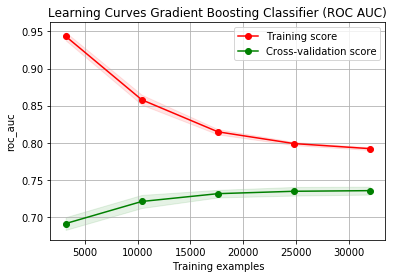

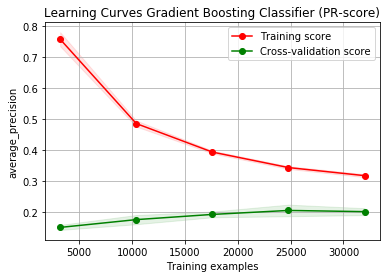

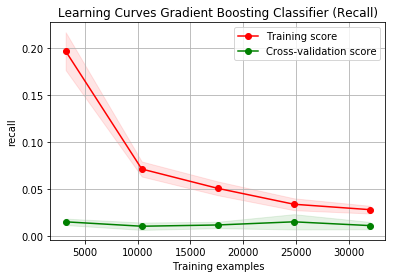

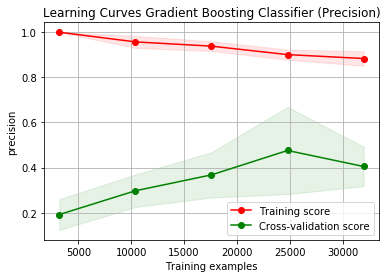

In [14]:
cv = StratifiedKFold(n_splits=5, random_state=123)
estimator = GradientBoostingClassifier()
title = "Learning Curves Gradient Boosting Classifier (ROC AUC)"
plot_learning_curve(estimator, title, scoring='roc_auc', X=data_transformed['X'], y=y, cv=cv, n_jobs=1)
title = "Learning Curves Gradient Boosting Classifier (PR-score)"
plot_learning_curve(estimator, title, scoring='average_precision', X=data_transformed['X'], y=y, cv=cv, n_jobs=1)
title = "Learning Curves Gradient Boosting Classifier (Recall)"
plot_learning_curve(estimator, title, scoring='recall', X=data_transformed['X'], y=y, cv=cv, n_jobs=1)
title = "Learning Curves Gradient Boosting Classifier (Precision)"
plot_learning_curve(estimator, title, scoring='precision', X=data_transformed['X'], y=y, cv=cv, n_jobs=1)
plt.show()

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

* С изменением доли класса "отток" метрики существенно изменяются
* Метрики растут, модель улучшается
* Оптимальным является модель, в которой доли классов "отток" и "не отток" приблизительно одинаковы

In [15]:
neg_frac = [0.68, 0.30, 0.16, 0.11, 0.09, 0.075]
positive_fraction = []
gbc = GradientBoostingClassifier()

for each_frac in neg_frac:
    print('neg_frac = {0}'.format(each_frac))
    X_1, y_1, pos_frac, _, _ = resample_data(data_transformed['X'], y, 1., each_frac)
    configuration='Positive class fraction = ' + str(round(pos_frac, 2))
    positive_fraction.append(pos_frac)
    get_scores(X_1, y_1, gbc, configuration, scores_cv)
    gbc.fit(X_1, y_1)
    get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

neg_frac = 0.68
The new size is 28152, the positive and negative class fractions are 0.11 and 0.89
Calculating scores...
Done!
Calculating scores...
Done!
neg_frac = 0.3
The new size is 14083, the positive and negative class fractions are 0.21 and 0.79
Calculating scores...
Done!
Calculating scores...
Done!
neg_frac = 0.16
The new size is 8899, the positive and negative class fractions are 0.33 and 0.67
Calculating scores...
Done!
Calculating scores...
Done!
neg_frac = 0.11
The new size is 7048, the positive and negative class fractions are 0.42 and 0.58
Calculating scores...
Done!
Calculating scores...
Done!
neg_frac = 0.09
The new size is 6308, the positive and negative class fractions are 0.47 and 0.53
Calculating scores...
Done!
Calculating scores...
Done!
neg_frac = 0.075
The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


In [16]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514


In [17]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084


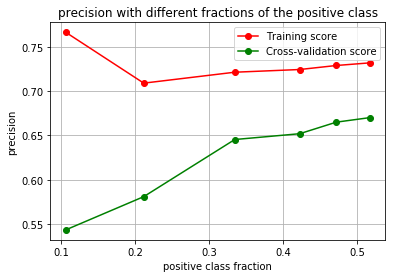

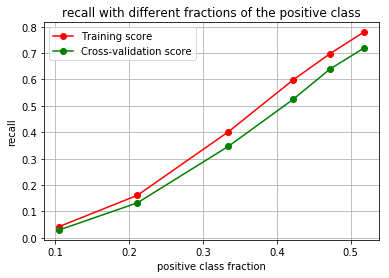

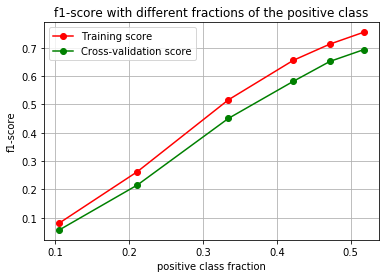

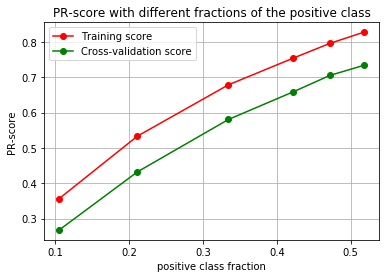

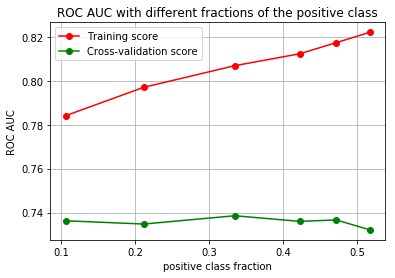

In [18]:
for each_score in scores_train.columns:
    plt.figure()
    
    title = each_score + ' with different fractions of the positive class'
    plt.title(title)
    plt.xlabel('positive class fraction')
    plt.ylabel(each_score)
    plt.grid()
    
    train_col = each_score
    cross_val_col = each_score + ' ' + 'test'
    
    plt.plot(positive_fraction, np.array(scores_train[train_col]), 'o-', color="r",
                 label="Training score")
    plt.plot(positive_fraction, np.array(scores_cv[cross_val_col]), 'o-', color="g",
                 label="Cross-validation score")

    plt.legend(loc="best")
plt.show()

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

* RandomUnderSampler и InstanceHardnessThreshold - почти не меняются, NearMiss - меняются
* RandomUnderSampler и InstanceHardnessThreshold - почти не изменяется, NearMiss - качетсво улучшается
* NearMiss - оптимальный выбор

In [19]:
iht = InstanceHardnessThreshold(random_state=0)
random_us = RandomUnderSampler(random_state=0)
near_miss = NearMiss(random_state=0)

In [20]:
X_resampled_rand, y_resampled_rand = random_us.fit_sample(data_transformed['X'], y)

In [21]:
X_resampled_near, y_resampled_near = near_miss.fit_sample(data_transformed['X'], y)

In [22]:
X_resampled_iht, y_resampled_iht = iht.fit_sample(data_transformed['X'], y)

In [23]:
get_scores(X_resampled_rand, y_resampled_rand, gbc, 'RandomUnderSampler', scores_cv)
gbc.fit(X_resampled_rand, y_resampled_rand)
get_scores_hold_out(X_resampled_rand, y_resampled_rand, gbc, 'RandomUnderSampler', scores_train)

get_scores(X_resampled_near, y_resampled_near, gbc, 'NearMiss UnderSampler', scores_cv)
gbc.fit(X_resampled_near, y_resampled_near)
get_scores_hold_out(X_resampled_near, y_resampled_near, gbc, 'NearMiss UnderSampler', scores_train)

get_scores(X_resampled_iht, y_resampled_iht, gbc, 'InstanceHardnessThreshold UnderSampler', scores_cv)
gbc.fit(X_resampled_iht, y_resampled_iht)
get_scores_hold_out(X_resampled_iht, y_resampled_iht, gbc, 'InstanceHardnessThreshold UnderSampler', scores_train)

Calculating scores...
Done!
Calculating scores...
Done!
Calculating scores...
Done!
Calculating scores...
Done!
Calculating scores...
Done!
Calculating scores...
Done!


True

In [24]:
print(X_resampled_rand.shape[0])
print(X_resampled_rand[y_resampled_rand==1].shape[0] /float(X_resampled_rand.shape[0]))
print(X_resampled_near.shape[0])
print(X_resampled_near[y_resampled_near==1].shape[0] /float(X_resampled_near.shape[0]))
print(X_resampled_iht.shape[0])
print(X_resampled_iht[y_resampled_iht==1].shape[0] /float(X_resampled_iht.shape[0]))

5952
0.5
5952
0.5
20617
0.1443468981908134


In [26]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514
RandomUnderSampler,0.667147,0.734895,0.694553,0.767053,0.68044,0.750612,0.724784,0.823841,0.735272,0.830512
NearMiss UnderSampler,0.824846,0.897813,0.67541,0.743784,0.742652,0.813564,0.877452,0.929137,0.852617,0.915934
InstanceHardnessThreshold UnderSampler,0.686542,0.767378,0.257055,0.291751,0.373709,0.422743,0.512349,0.598667,0.816627,0.858223


In [25]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084
RandomUnderSampler,0.721953,0.750336,0.735871,0.810379,0.817704
NearMiss UnderSampler,0.884412,0.730175,0.799926,0.921433,0.906948
InstanceHardnessThreshold UnderSampler,0.755157,0.28293,0.411635,0.588451,0.853209


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

* Качество классификации не сильно меняется при измении способа обработки пропущенных значений, иногда - незначительно ухудшает;
* Наиболее оптимальным с точки зрения качества является замена пропущенных значений матожиданием и нормализация

In [27]:
data_transformed['X']

<40000x212 sparse matrix of type '<class 'numpy.float64'>'
	with 8205377 stored elements in Compressed Sparse Row format>

In [28]:
y

array([-1, -1, -1, ..., -1, -1, -1])

In [29]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_median = transform_data(data=data, imput_method='median')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Processing the categorical columns...
Filling the absent categorical values...
Applying a LabelEncoder to the categorical columns...
Joining the numerical and categorical c

In [30]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_freq = transform_data(data=data, imput_method='most_frequent')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Processing the categorical columns...
Filling the absent categorical values...
Applying a LabelEncoder to the categorical columns...
Joining the numerical and categorical c

In [31]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_mean = transform_data(data=data, imput_method='mean')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Processing the categorical columns...
Filling the absent categorical values...
Applying a LabelEncoder to the categorical columns...
Joining the numerical and categorical c

In [32]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_transformed['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' fill NaNs with means + normalization'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [33]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_mean['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' fill NaNs with means, no normalization'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [34]:
X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_median['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' fill NaNs with medians'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [35]:
X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_freq['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' fill NaNs with the most frequent'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [36]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514
RandomUnderSampler,0.667147,0.734895,0.694553,0.767053,0.68044,0.750612,0.724784,0.823841,0.735272,0.830512
NearMiss UnderSampler,0.824846,0.897813,0.67541,0.743784,0.742652,0.813564,0.877452,0.929137,0.852617,0.915934
InstanceHardnessThreshold UnderSampler,0.686542,0.767378,0.257055,0.291751,0.373709,0.422743,0.512349,0.598667,0.816627,0.858223
Positive class fraction = 0.52 fill NaNs with means + normalization,0.670491,0.741787,0.717065,0.793095,0.692881,0.766533,0.733191,0.839055,0.731737,0.83515


In [37]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084
RandomUnderSampler,0.721953,0.750336,0.735871,0.810379,0.817704
NearMiss UnderSampler,0.884412,0.730175,0.799926,0.921433,0.906948
InstanceHardnessThreshold UnderSampler,0.755157,0.28293,0.411635,0.588451,0.853209
Positive class fraction = 0.52 fill NaNs with means + normalization,0.731923,0.778898,0.75468,0.827556,0.822084


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?
 * Обработка только LableEncoder() и обработка композицией LableEncoder() + OneHotEncoder() дают одинаковое качество модели;
 * Оптимальным с точки зрения качества является обработка LableEncoder() без OneHotEncoder()

In [39]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_LE = transform_data(data=data)

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [40]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_LE_OHE = transform_data(data=data, is_OHE=True)

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [41]:
X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_LE['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + LableEncoder()'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [42]:
X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_LE_OHE['X'].tocsr(), y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + LableEncoder() + OneHotEncoder()'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [43]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514
RandomUnderSampler,0.667147,0.734895,0.694553,0.767053,0.68044,0.750612,0.724784,0.823841,0.735272,0.830512
NearMiss UnderSampler,0.824846,0.897813,0.67541,0.743784,0.742652,0.813564,0.877452,0.929137,0.852617,0.915934
InstanceHardnessThreshold UnderSampler,0.686542,0.767378,0.257055,0.291751,0.373709,0.422743,0.512349,0.598667,0.816627,0.858223
Positive class fraction = 0.52 fill NaNs with means + normalization,0.670491,0.741787,0.717065,0.793095,0.692881,0.766533,0.733191,0.839055,0.731737,0.83515


In [44]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084
RandomUnderSampler,0.721953,0.750336,0.735871,0.810379,0.817704
NearMiss UnderSampler,0.884412,0.730175,0.799926,0.921433,0.906948
InstanceHardnessThreshold UnderSampler,0.755157,0.28293,0.411635,0.588451,0.853209
Positive class fraction = 0.52 fill NaNs with means + normalization,0.731923,0.778898,0.75468,0.827556,0.822084


5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

* Отбор признаков как на базе l1-регуляризации, так и на базе дерьевьев, сохранил качество, но при этом уменьшил количество используемых признаков, то есть итоговая модель требует меньшее количество информации, меньше вычислительных мощностей. Это увеличивает быстродействие, поэтому качество модели в целом улучшилось

In [46]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_l1 = transform_data(data=data, y=y, feature_selection='l1')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [47]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_tree = transform_data(data=data, y=y, feature_selection='tree')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [50]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_transformed_top_20_num = transform_data(data=data,y=y, num_cols=num_top_20)

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [95]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_result_l1_OHE = transform_data(data=data, y=y, is_OHE=True, feature_selection='l1')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [96]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_result_tree_OHE = transform_data(data=data, y=y, is_OHE=True, feature_selection='tree')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [97]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_l1['X'], y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + l1-based feature selection'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [98]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_tree['X'], y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + tree-based feature selection'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [99]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_transformed_top_20_num['X'], y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + 20 selected correlation-based features'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [100]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_result_l1_OHE['X'], y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + '+ OneHotEncoder() + l1-based feature selection'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [101]:
each_frac = 0.075

X_1, y_1, pos_frac, _, _ = resample_data(data_result_tree_OHE['X'], y, 1., each_frac)
configuration='Positive class fraction = ' + str(round(pos_frac, 2)) + ' + OneHotEncoder() + tree-based feature selection'

get_scores(X_1, y_1, gbc, configuration, scores_cv)
gbc.fit(X_1, y_1)
get_scores_hold_out(X_1, y_1, gbc, configuration, scores_train)

The new size is 5752, the positive and negative class fractions are 0.52 and 0.48
Calculating scores...
Done!
Calculating scores...
Done!


True

In [102]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514
RandomUnderSampler,0.667147,0.734895,0.694553,0.767053,0.68044,0.750612,0.724784,0.823841,0.735272,0.830512
NearMiss UnderSampler,0.824846,0.897813,0.67541,0.743784,0.742652,0.813564,0.877452,0.929137,0.852617,0.915934
InstanceHardnessThreshold UnderSampler,0.686542,0.767378,0.257055,0.291751,0.373709,0.422743,0.512349,0.598667,0.816627,0.858223
Positive class fraction = 0.52 fill NaNs with means + normalization,0.670491,0.741787,0.717065,0.793095,0.692881,0.766533,0.733191,0.839055,0.731737,0.83515


In [103]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084
RandomUnderSampler,0.721953,0.750336,0.735871,0.810379,0.817704
NearMiss UnderSampler,0.884412,0.730175,0.799926,0.921433,0.906948
InstanceHardnessThreshold UnderSampler,0.755157,0.28293,0.411635,0.588451,0.853209
Positive class fraction = 0.52 fill NaNs with means + normalization,0.731923,0.778898,0.75468,0.827556,0.822084


6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

   * Качество модели незначительно улучшилось по сравнению с вариантом NearMiss UnderSampler

In [105]:
near_miss = NearMiss(random_state=0)
X_resampled_LE, y_resampled_LE = near_miss.fit_sample(data_transformed_tree['X'], y)

In [106]:
print(X_resampled_LE.shape)

(5952, 70)


In [107]:
scoring = ['precision', 'recall', 'average_precision', 'roc_auc']

In [108]:
gbc = GradientBoostingClassifier(verbose=1)
parameters = {'learning_rate':[0.1, 0.07, 0.05], 'n_estimators':[100, 120, 150]}
gsv_clf = GridSearchCV(gbc, parameters, cv=5, verbose=1, scoring=scoring, refit='roc_auc', return_train_score=False)

In [109]:
gsv_clf.fit(X_resampled_LE, y_resampled_LE)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
      Iter       Train Loss   Remaining Time 
         1           1.3290            3.30m
         2           1.2814            1.87m
         3           1.2424            1.37m
         4           1.2085            1.09m
         5           1.1797           55.12s
         6           1.1548           48.37s
         7           1.1336           44.77s
         8           1.1142           40.25s
         9           1.0976           39.27s
        10           1.0823           37.65s
        20           0.9885           21.92s
        30           0.9384           15.48s
        40           0.9042           11.64s
        50           0.8763            9.04s
        60           0.8540            6.63s
        70           0.8331            4.70s
        80           0.8146            2.99s
        90           0.7983            1.43s
       100           0.7848            0.00s
      Iter       Train Loss   Remaining

         3           1.2449           10.30s
         4           1.2118           10.26s
         5           1.1832           10.19s
         6           1.1584           10.15s
         7           1.1370           10.08s
         8           1.1189            9.97s
         9           1.1022            9.89s
        10           1.0871            9.82s
        20           0.9931            8.85s
        30           0.9425            7.93s
        40           0.9057            7.02s
        50           0.8765            6.13s
        60           0.8527            5.25s
        70           0.8326            4.36s
        80           0.8143            3.49s
        90           0.7978            2.61s
       100           0.7823            1.74s
      Iter       Train Loss   Remaining Time 
         1           1.3290           13.94s
         2           1.2814           13.52s
         3           1.2424           13.41s
         4           1.2085           13.33s
         

         5           1.2324            8.31s
         6           1.2111            8.28s
         7           1.1915            8.21s
         8           1.1743            8.13s
         9           1.1582            8.07s
        10           1.1440            7.97s
        20           1.0470            7.04s
        30           0.9960            6.14s
        40           0.9598            5.26s
        50           0.9327            4.38s
        60           0.9115            3.50s
        70           0.8922            2.62s
        80           0.8741            1.75s
        90           0.8588            0.87s
       100           0.8457            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3463            8.72s
         2           1.3114            8.61s
         3           1.2806            8.63s
         4           1.2533            8.49s
         5           1.2292            8.43s
         6           1.2072            8.34s
         

         9           1.1518           12.53s
        10           1.1371           12.51s
        20           1.0403           11.61s
        30           0.9874           10.72s
        40           0.9525            9.84s
        50           0.9247            8.92s
        60           0.9028            8.02s
        70           0.8847            7.13s
        80           0.8681            6.24s
        90           0.8522            5.38s
       100           0.8383            4.48s
      Iter       Train Loss   Remaining Time 
         1           1.3470           13.23s
         2           1.3127           12.65s
         3           1.2826           17.11s
         4           1.2562           16.08s
         5           1.2324           15.43s
         6           1.2111           14.92s
         7           1.1915           14.54s
         8           1.1743           14.22s
         9           1.1582           13.98s
        10           1.1440           13.76s
        2

        20           1.0918            9.15s
        30           1.0370            8.25s
        40           1.0007            7.25s
        50           0.9740            6.35s
        60           0.9517            5.44s
        70           0.9348            4.52s
        80           0.9194            3.61s
        90           0.9055            2.71s
       100           0.8934            1.81s
      Iter       Train Loss   Remaining Time 
         1           1.3570           10.80s
         2           1.3304           10.19s
         3           1.3064           10.06s
         4           1.2844            9.99s
         5           1.2644            9.95s
         6           1.2458            9.87s
         7           1.2286            9.84s
         8           1.2128            9.84s
         9           1.1980            9.81s
        10           1.1843            9.76s
        20           1.0872            8.99s
        30           1.0309            8.11s
        4

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.4min finished


      Iter       Train Loss   Remaining Time 
         1           1.3299            2.43m
         2           1.2837            1.31m
         3           1.2455           56.30s
         4           1.2124           45.01s
         5           1.1843           38.24s
         6           1.1601           33.68s
         7           1.1387           30.40s
         8           1.1205           27.90s
         9           1.1038           25.94s
        10           1.0895           24.33s
        20           0.9985           16.50s
        30           0.9503           13.28s
        40           0.9184           11.10s
        50           0.8928            9.29s
        60           0.8711            7.71s
        70           0.8519            6.28s
        80           0.8348            4.95s
        90           0.8223            3.68s
       100           0.8106            2.42s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.07, 0.05], 'n_estimators': [100, 120, 150]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=False,
       scoring=['precision', 'recall', 'average_precision', 'roc_auc'],
       verbose=1)

In [110]:
GridSearch_scores = pd.DataFrame(gsv_clf.cv_results_)

In [111]:
GridSearch_scores

,mean_fit_time,mean_score_time,mean_test_average_precision,mean_test_precision,mean_test_recall,mean_test_roc_auc,param_learning_rate,param_n_estimators,params,rank_test_average_precision,...,split4_test_average_precision,split4_test_precision,split4_test_recall,split4_test_roc_auc,std_fit_time,std_score_time,std_test_average_precision,std_test_precision,std_test_recall,std_test_roc_auc
0,10.029903,0.207216,0.877732,0.824354,0.676747,0.852603,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",2,...,0.867505,0.798020,0.677311,0.840878,2.383400,0.316873,0.011097,0.018963,0.008080,0.011509
1,10.528921,0.054912,0.878028,0.817975,0.679772,0.853199,0.1,120,"{'learning_rate': 0.1, 'n_estimators': 120}",1,...,0.866440,0.785575,0.677311,0.840113,0.055041,0.000379,0.011165,0.019387,0.011986,0.011218
2,13.094404,0.064382,0.877565,0.815553,0.682124,0.852594,0.1,150,"{'learning_rate': 0.1, 'n_estimators': 150}",3,...,0.865833,0.792233,0.685714,0.839381,0.098407,0.001444,0.010990,0.018631,0.008650,0.011124
3,8.741413,0.047819,0.876928,0.832622,0.661290,0.851710,0.07,100,"{'learning_rate': 0.07, 'n_estimators': 100}",7,...,0.865344,0.803313,0.652101,0.838083,0.016555,0.000172,0.012276,0.021366,0.014763,0.012208
4,10.576246,0.054496,0.877134,0.825750,0.669691,0.852072,0.07,120,"{'learning_rate': 0.07, 'n_estimators': 120}",6,...,0.866076,0.797546,0.655462,0.838842,0.150538,0.000390,0.012185,0.020441,0.012186,0.012319
5,13.332615,0.064434,0.877149,0.817104,0.677419,0.852336,0.07,150,"{'learning_rate': 0.07, 'n_estimators': 150}",5,...,0.865214,0.789370,0.673950,0.838719,0.112730,0.000951,0.011557,0.021321,0.013247,0.011511
6,9.038624,0.050819,0.874881,0.846236,0.640121,0.848812,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",9,...,0.865511,0.826552,0.648739,0.836558,0.286904,0.003449,0.011866,0.019756,0.023149,0.011755
7,10.853022,0.060159,0.876486,0.838910,0.650874,0.850821,0.05,120,"{'learning_rate': 0.05, 'n_estimators': 120}",8,...,0.867079,0.825902,0.653782,0.839079,0.057710,0.003076,0.012203,0.019041,0.017189,0.011927
8,13.295146,0.064613,0.877300,0.829886,0.661962,0.852227,0.05,150,"{'learning_rate': 0.05, 'n_estimators': 150}",4,...,0.866747,0.811715,0.652101,0.839538,0.353545,0.000573,0.012339,0.020846,0.015115,0.012151


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

* Фунцкия на основе `feature_importances_` данных отборщика признаков возвращает признаки, ранжированные в порядке убывания важности

In [119]:
# Топ-30 наиболее важных признаков
data_transformed_tree['feature_ranking'][:30]

Index(['Var118', 'Var49', 'Var11', 'Var122', 'Var4', 'Var27', 'Var93',
       'Var116', 'Var142', 'Var29', 'Var26', 'Var43', 'Var34', 'Var67',
       'Var90', 'Var2', 'Var110', 'Var100', 'Var95', 'Var84', 'Var108',
       'Var178', 'Var138', 'Var47', 'Var36', 'Var137', 'Var131', 'Var14',
       'Var129', 'Var215'],
      dtype='object')

In [138]:
# Топ-30 наименее важных признаков
data_transformed_tree['feature_ranking'][-30:]

Index(['Var109', 'Var25', 'Var134', 'Var218', 'Var6', 'Var38', 'Var73',
       'Var133', 'Var153', 'Var205', 'Var163', 'Var119', 'Var76', 'Var81',
       'Var28', 'Var189', 'Var222', 'Var216', 'Var226', 'Var217', 'Var198',
       'Var192', 'Var197', 'Var199', 'Var204', 'Var220', 'Var202', 'Var57',
       'Var126', 'Var113'],
      dtype='object')

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли между этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

* Исходя из датафрейма Out[174], можно заметить, что объекты имеют схожие значения в признаках 64-69. Вероятно, такие комбинации признаков 64-69 наиболее характерны для класса "отток", поэтому классификатор на них ошибается с большой ошибкой

In [139]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=120)

In [140]:
data_transformed_tree

{'X': <40000x70 sparse matrix of type '<class 'numpy.float64'>'
 	with 2608048 stored elements in Compressed Sparse Row format>,
 'cat_interval': (175, 212),
 'feature_importances': array([  2.18784688e-04,   9.80160857e-05,   2.12297676e-04,
          3.86411637e-05,   3.21916838e-04,   1.61548030e-02,
          1.01320647e-02,   2.13217683e-04,   3.34947991e-04,
          2.72048002e-05,   3.02683880e-04,   1.33302916e-02,
          1.36316726e-04,   6.17350469e-04,   3.68970387e-04,
          2.16897503e-04,   1.93768791e-04,   1.40148553e-02,
          1.46823381e-02,   1.61987114e-04,   1.38295540e-02,
          1.55930620e-02,   8.70270959e-05,   5.65179449e-05,
          1.76139184e-02,   8.34585340e-05,   1.79723773e-04,
          3.07237561e-04,   9.24580443e-05,   6.52517708e-03,
          1.21462484e-04,   2.86678818e-04,   1.63686919e-02,
          1.53643101e-04,   2.01741477e-04,   9.23867248e-05,
          1.72339768e-03,   1.47580356e-04,   3.81172524e-04,
          1.1

In [141]:
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X_resampled_LE, y_resampled_LE, 
                                                            test_size=0.2, random_state=123, 
                                                            stratify=y_resampled_LE)

In [142]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [143]:
class_proba = gbc.predict_proba(X_hold_out)

In [144]:
error_rate = pd.DataFrame(columns=['label', '                                                                                                   probability'])
error_rate.label = y_hold_out
error_rate.probability = class_proba[:,1]

In [145]:
error_rate[error_rate.label==-1][error_rate.probability>0.7]

/home/placetexperiri/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,label,probability
122,-1,0.840975
125,-1,0.766646
161,-1,0.714476
306,-1,0.715289
377,-1,0.720987
408,-1,0.729546
411,-1,0.738385
489,-1,0.734569
491,-1,0.780573
528,-1,0.707796


In [146]:
wrong_classified = pd.DataFrame(X_hold_out[error_rate[error_rate.label==-1][error_rate.probability>0.7].index].toarray())

/home/placetexperiri/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [147]:
wrong_classified

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.456688,-1.145757,-0.495629,-0.382639,-0.377555,-2.730890e-01,-0.478680,0.345459,-0.254534,-0.902594,...,20.0,3088.0,4.0,1300.0,4.0,2.0,7.0,2.0,8.0,4.0
1,-0.246206,0.035066,-0.371421,-0.185516,-0.180612,-4.908111e-01,-0.359294,-2.075824,-0.254534,1.013851,...,11.0,537.0,4.0,114.0,0.0,2.0,2.0,2.0,8.0,4.0
2,-0.260427,0.035066,-0.486074,-0.140026,-0.135164,-5.536680e-02,-0.080726,-2.198093,8.707446,0.906242,...,11.0,783.0,4.0,909.0,0.0,2.0,18.0,2.0,8.0,4.0
3,1.582716,0.035066,0.380195,2.612117,2.614459,3.863632e+00,2.704957,-0.981425,-0.254534,-0.864933,...,6.0,3207.0,3.0,2828.0,3.0,2.0,1.0,4.0,25.0,1.0
4,-0.177941,0.035066,0.837216,-0.117281,-0.112439,1.623554e-01,-0.438885,-0.981425,-0.254534,2.907366,...,20.0,328.0,6.0,2498.0,4.0,2.0,7.0,3.0,15.0,4.0
5,-0.499354,-1.145757,-0.495629,-0.185516,-0.180612,1.623554e-01,-0.359294,-2.198093,-0.254534,-0.893859,...,20.0,1721.0,4.0,653.0,4.0,2.0,7.0,2.0,8.0,4.0
6,-0.470910,-1.145757,-0.495629,-0.215843,-0.210911,-5.536680e-02,-0.319498,0.674381,-0.254534,0.030957,...,11.0,2644.0,4.0,634.0,0.0,2.0,2.0,2.0,8.0,4.0
7,-0.516420,-1.145757,-0.495629,-0.238588,-0.233635,-4.908111e-01,-0.359294,-2.039660,3.330258,-0.531814,...,11.0,898.0,4.0,438.0,0.0,2.0,7.0,2.0,8.0,4.0
8,-0.121054,0.035066,-0.490852,-0.094536,-0.089715,-4.908111e-01,-0.160317,2.699579,-0.254534,0.665737,...,11.0,743.0,4.0,234.0,0.0,2.0,7.0,2.0,8.0,4.0
9,-0.308782,-1.145757,-0.495629,-0.443293,-0.438152,4.399307e-14,-0.478680,0.062172,-0.254534,-0.902594,...,11.0,3352.0,4.0,2502.0,0.0,2.0,2.0,2.0,8.0,4.0


9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Итоговая модель имеет следующие параметры:
* Заполнение средним значением пропущенных числовых данных и последующая нормализация;
* Заполнение пропущенных категориальных данных 'unknown' и использование LabelEncoding()
* Отбор признаков с помощью tree-based feature selection model
* Использование NearMiss UnderSampling model
* n_estimators=120

In [148]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')

data_result_model = transform_data(data=data, y=y, feature_selection='tree')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [149]:
near_miss = NearMiss(random_state=0)
X_resampled_result, y_resampled_result = near_miss.fit_sample(data_result_model['X'], y)

In [150]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=120)

In [151]:
get_scores(X_resampled_result, y_resampled_result, gbc, 'final model', scores_cv)
gbc.fit(X_resampled_result, y_resampled_result)
get_scores_hold_out(X_resampled_result, y_resampled_result, gbc, 'final model', scores_train)

Calculating scores...
Done!
Calculating scores...
Done!


True

In [152]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
Positive class fraction = 0.11,0.543336,0.802362,0.0302397,0.048051,0.0572347,0.0905694,0.267859,0.37886,0.736245,0.7939
Positive class fraction = 0.21,0.580892,0.7348,0.13273,0.171034,0.215669,0.277421,0.432115,0.555641,0.734751,0.808143
Positive class fraction = 0.33,0.645367,0.735712,0.346785,0.410786,0.45063,0.52707,0.580529,0.693886,0.738533,0.81657
Positive class fraction = 0.42,0.651932,0.738259,0.52521,0.60988,0.581503,0.667917,0.658956,0.770807,0.735974,0.82293
Positive class fraction = 0.47,0.664977,0.740377,0.639449,0.711441,0.651841,0.725551,0.705328,0.811321,0.736613,0.830574
Positive class fraction = 0.52,0.670118,0.74205,0.718073,0.793011,0.693176,0.766639,0.733713,0.839188,0.732077,0.835514
RandomUnderSampler,0.667147,0.734895,0.694553,0.767053,0.68044,0.750612,0.724784,0.823841,0.735272,0.830512
NearMiss UnderSampler,0.824846,0.897813,0.67541,0.743784,0.742652,0.813564,0.877452,0.929137,0.852617,0.915934
InstanceHardnessThreshold UnderSampler,0.686542,0.767378,0.257055,0.291751,0.373709,0.422743,0.512349,0.598667,0.816627,0.858223
Positive class fraction = 0.52 fill NaNs with means + normalization,0.670491,0.741787,0.717065,0.793095,0.692881,0.766533,0.733191,0.839055,0.731737,0.83515


In [153]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
Positive class fraction = 0.11,0.766467,0.0430108,0.0814508,0.356719,0.784093
Positive class fraction = 0.21,0.70901,0.16129,0.262798,0.533307,0.797007
Positive class fraction = 0.33,0.721351,0.401882,0.516185,0.678596,0.806856
Positive class fraction = 0.42,0.72439,0.59879,0.655629,0.754367,0.812276
Positive class fraction = 0.47,0.728933,0.697581,0.712912,0.796059,0.817358
Positive class fraction = 0.52,0.731923,0.778898,0.75468,0.827556,0.822084
RandomUnderSampler,0.721953,0.750336,0.735871,0.810379,0.817704
NearMiss UnderSampler,0.884412,0.730175,0.799926,0.921433,0.906948
InstanceHardnessThreshold UnderSampler,0.755157,0.28293,0.411635,0.588451,0.853209
Positive class fraction = 0.52 fill NaNs with means + normalization,0.731923,0.778898,0.75468,0.827556,0.822084


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

* Пресказывать пропущенных значений числовых и категориальных признаков, а не заполнять их средним значением или 'unknown'
* Использовать OverSampling вместо UnderSampling